@dataset{
    dataset,
    author = {Timilsina, Bimal},
    year = {2021},
    month = {08},
    pages = {},
    title = {News Article Category Dataset},
}

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../input/newsarticlecategories/news-article-categories.csv')

In [3]:
df['category'] = df['category'].astype('category')

In [4]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import re
from nltk import word_tokenize

def tokenize_title(title):
    tokens = word_tokenize(title)
    cleaned = []
    for t in tokens:
        if t.lower() in stopwords:
            continue
        t = re.sub(r'(?i)\d{1,3}-year-old', 'AGE', t)
        t = re.sub(r'[^A-Za-z0-9]', '', t).strip()
        t = re.sub(r'^20\d{2}$', '21STCENTURY',t)
        t = re.sub(r'^19\d{2}$', '20THCENTURY',t)
        t = re.sub(r'^\d+$', 'NUMBERCOUNT', t)
        if len(t) > 1:
            cleaned.append(t)
    return cleaned

In [6]:
df['tokenized'] = df['title'].map(tokenize_title)

In [7]:
from sklearn.model_selection import train_test_split

x = df.drop('category', axis=1)
y = df['category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

with pd.option_context('display.max_colwidth', 500):
    print(x_train_full_text)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

def identity_tokenizer(t):
    return t

model = make_pipeline(TfidfVectorizer(stop_words=stopwords, lowercase=True), MultinomialNB())

model.fit(x_train['title'], y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('multinomialnb', MultinomialNB())])

In [9]:
labels = model.predict(x_test['title'])

In [10]:
display(y_test)
display(labels)

6341              TECH
4323          POLITICS
1626            COMEDY
3803             MEDIA
984     ARTS & CULTURE
             ...      
7       ARTS & CULTURE
3839             MEDIA
5829            SPORTS
2663         EDUCATION
6772             WOMEN
Name: category, Length: 1376, dtype: category
Categories (14, object): ['ARTS & CULTURE', 'BUSINESS', 'COMEDY', 'CRIME', ..., 'SCIENCE', 'SPORTS', 'TECH', 'WOMEN']

array(['TECH', 'POLITICS', 'COMEDY', ..., 'SPORTS', 'ARTS & CULTURE',
       'RELIGION'], dtype='<U14')

In [11]:
from sklearn.metrics import confusion_matrix, f1_score

category_names = pd.unique(y_train).sort_values()
mat = confusion_matrix(y_test, labels, labels=category_names)
f1_score_result = f1_score(y_test, labels, average='micro')

0.5268895348837209
[[201  55  29  27  28  55  25  33  30  39  38  30  34  47]
 [  0  31   0   0   2   0   4   0   3   0   0   0   9   0]
 [  0   0  37   0   0   4   0   1   2   1   0   0   0   0]
 [  0   0   0  21   0   1   0   0   1   0   0   1   0   0]
 [  2   1   0   0  55   2   0   0   3   1   2   0   1   3]
 [  1   0   4   0   1  31   0   2   1   0   0   0   3   2]
 [  2   1   0   1   1   0  44   0   1   1   7   3   4   1]
 [  0   0   1   1   0   0   0  23   2   1   0   0   0   0]
 [  0   1   4   4   0   1   0   7  61   3   0   1   0   2]
 [  1   1   1   0   0   0   1   0   1  48   0   0   1   6]
 [  0   0   0   0   0   1   0   0   0   0  16   0   0   0]
 [  0   1   2   1   1   1   3   0   1   2   2  68   0   2]
 [  1   9   0   2   0   0   0   2   1   1   3   0  57   1]
 [  1   5   1   4   1   3   0   3   1   3   1   1   0  32]]


Text(109.44999999999997, 0.5, 'predicted label')

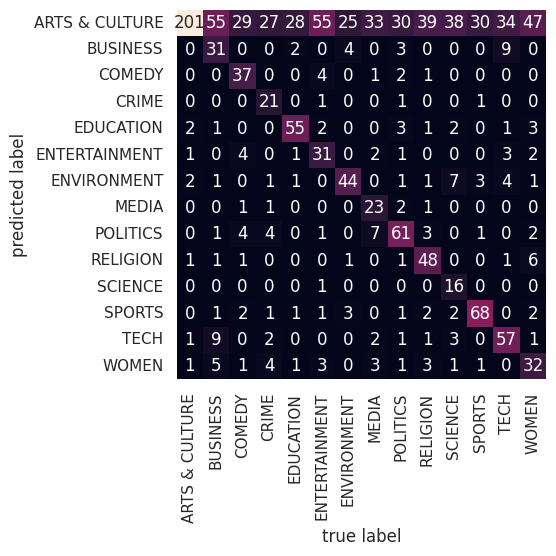

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

print(f1_score_result)

print(mat.T)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=category_names, yticklabels=category_names)
plt.xlabel('true label')
plt.ylabel('predicted label')